In [1]:
import requests
import json

from shapely.ops import linemerge
from shapely.geometry import LineString, Polygon, MultiPolygon

from geopandas import GeoDataFrame

import matplotlib.pyplot as plt

In [2]:
def query_city_subdivisions(name, admin_level):
    """
        Query OSM overpass-api for realtionships, which 
        represent administrative entities within a city.
        see https://wiki.openstreetmap.org/wiki/Tag:boundary%3Dadministrative 
        for info about admin_level
    """
    
    # see overpass query language
    overpass_query =f"""
    [out:json];
    area[name='{name}'];
    (rel[admin_level='{admin_level}'](area););
    out geom meta;
    """
    
    api_url = "http://overpass-api.de/api/interpreter"
    response = requests.get(api_url, params={'data': overpass_query})
    # print response status code
    print(response)
    data = response.json()
    return data

In [3]:
def json_to_gdf(data, tags=None):
    """
        Convert dictionary from OVERPASS response json to a GeoDataFrame.
        Works for closed contours like district boundaries etc.
    """
    districts = []
    # queried entities are stored in 'elements' item
    for element in data['elements']:
        mline = []
        # the geometries (relationships) consists from 'members'
        # these are separate lines forming closed contours
        if element.get('members'):
            for member in element['members']:
                try:
                    mline.append(LineString([(m['lon'], m['lat']) for m in member['geometry']]))
                except KeyError:
                    pass
            mline = linemerge(mline)
        else:
            try:
                mline.append(LineString([(m['lon'], m['lat']) for m in element['geometry']]))
            except KeyError:
                pass
            mline = linemerge(mline)
        # some contours may be represented by MultiPolygons
        try:
            mline = Polygon(mline)
        except NotImplementedError:
            d = []
            for line in mline:
                d.append(Polygon(line))
            mline = MultiPolygon(d)
        if tags:
            items = [element['tags'].get(tag, 0) for tag in tags]
            districts.append((*items, mline))
            gdf = GeoDataFrame(data=districts, columns=[*tags, 'geometry'], crs={'init': 'epsg:4326'})
        else:
            districts.append((mline, ))
            gdf = GeoDataFrame(data=districts, columns=['geometry', ], crs={'init': 'epsg:4326'})
    # OSM uses 'epsg:4326' (aka WGS84)
    
    return gdf

In [4]:
def plot_subdivision_map(gdf, annotate=True):
    """
        Plot the geodataframe (gdf), containing 'name' and 'geomnetry'.
    """
    if annotate:
        gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
        gdf['coords'] = [coords[0] for coords in gdf['coords']]
    fig, ax = plt.subplots(figsize=(30,20))
    gdf.plot(color='#fcba03', edgecolor='k', ax=ax)
    if annotate:
        for idx, row in gdf.iterrows():
            plt.annotate(s=row['name'], xy=row['coords'], horizontalalignment='center', fontsize=8)
    plt.show()

<Response [200]>


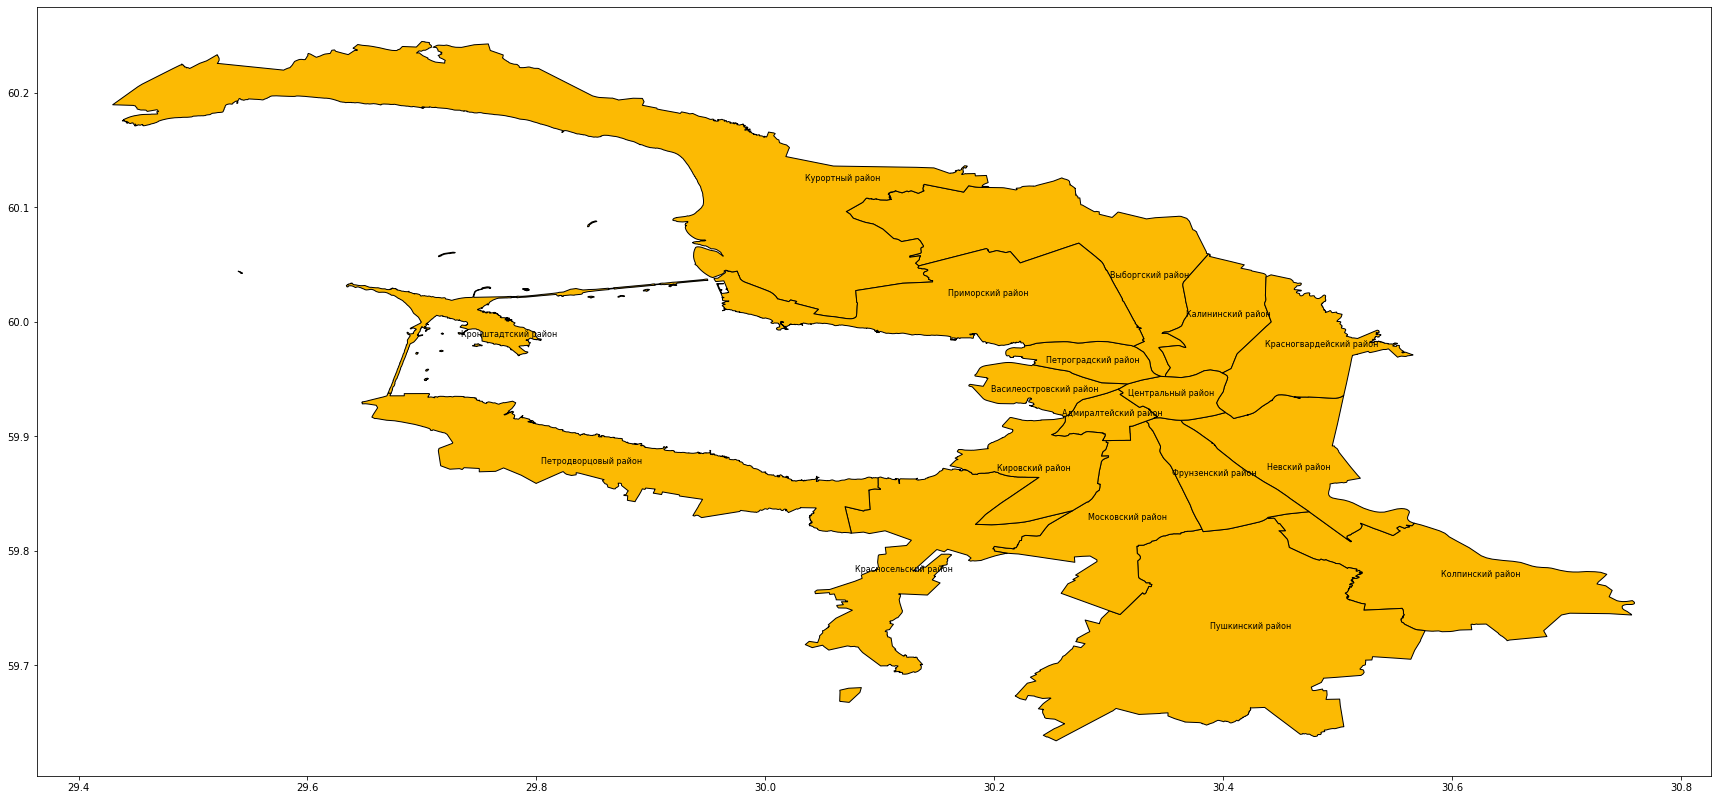

In [34]:
data_districts = query_city_subdivisions('Санкт-Петербург', 5)
gdf_districts = json_to_gdf(data_districts, ['name', ])
plot_subdivision_map(gdf_districts)
gdf.to_csv('districts.csv')

<Response [200]>


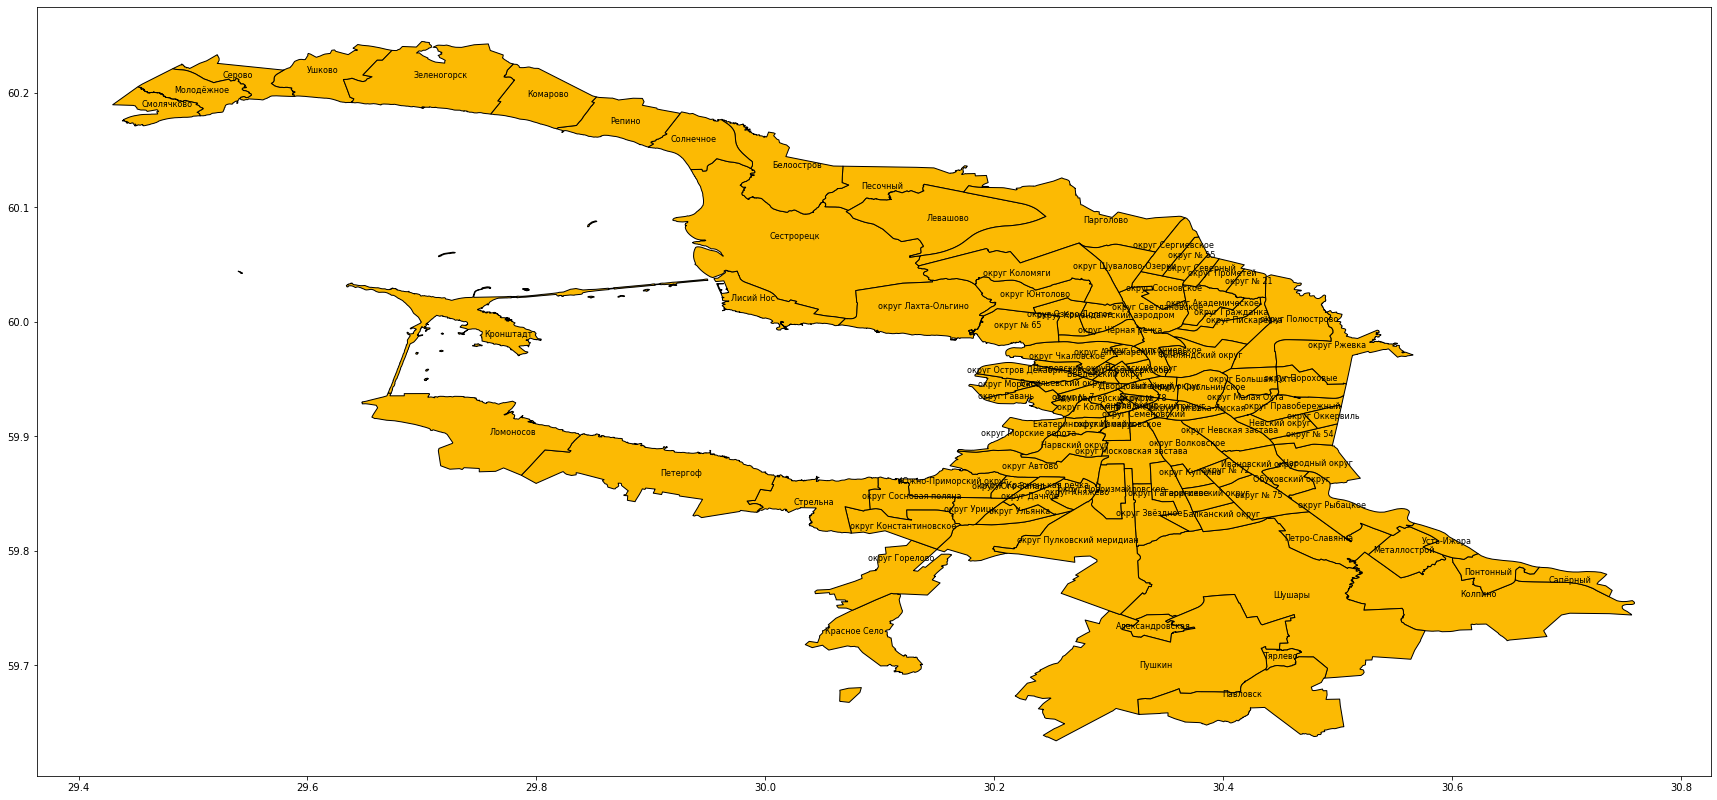

In [44]:
data_municip = query_city_subdivisions('Санкт-Петербург', 8)
gdf_municip = json_to_gdf(data_municip, ['name', ])
plot_subdivision_map(gdf_municip)
gdf_municip.to_csv('municipalities.csv')

### Under Consideration

In [5]:
overpass_query =f"""
    [out:json];
    area[name='Санкт-Петербург'];
    (way[building=''](area););
    out geom meta;
    """
    
api_url = "http://overpass-api.de/api/interpreter"
response = requests.get(api_url, params={'data': overpass_query})
# print response status code
print(response)
data = response.json()

<Response [200]>


In [6]:
len(data['elements'])

484400

In [7]:
gdf = json_to_gdf(data)

ValueError: A LinearRing must have at least 3 coordinate tuples

In [40]:
gdf.to_csv('data/buildings.csv')

In [12]:
import geopandas as gpd
import pandas as pd
from shapely import wkt

In [ ]:
buildings = gdf.to_crs(epsg='4326')
import folium

mapa = folium.Map(location=[59.9393773,30.3181802], zoom_start=10, tiles='Stamen Toner',)

folium.Choropleth(buildings).add_to(m)

mapa

In [13]:
municipalities = pd.read_csv('data/buildings.csv', index_col=0)
municipalities['geometry'] = municipalities['geometry'].apply(wkt.loads)
municipalities = GeoDataFrame(municipalities, crs={'init': 'epsg:4326'}, geometry='geometry')
municipalities = municipalities.dropna(subset=('geometry',))

In [18]:
def plot_subdivision_map(gdf, annotate=True):
    """
        Plot the geodataframe (gdf), containing 'name' and 'geomnetry'.
    """
    if annotate:
        gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
        gdf['coords'] = [coords[0] for coords in gdf['coords']]
    fig, ax = plt.subplots(figsize=(300,200))
    gdf.plot(color='#fcba03', edgecolor='k', ax=ax)
    if annotate:
        for idx, row in gdf.iterrows():
            plt.annotate(s=row['name'], xy=row['coords'], horizontalalignment='center', fontsize=8)
    plt.ylim(59.6, 60.3)
    plt.xlim(29.4, 30.8)
    plt.show()